<a href="https://colab.research.google.com/github/STORM-codess/T20-score-predictor-using-powerplay-data/blob/main/Final_score_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**🏏 IPL First Innings Score Prediction & Powerplay Analysis**  

---

In this project, I utilized **IPL data from 2022, 2023, and 2024** to extract detailed powerplay statistics (first 6 overs) for the first innings of matches. By analyzing key features such as **runs scored, wickets lost, boundary count, and dot balls**, I implemented **Linear Regression (LR)**, **Random Forest (RF)**, and a **Deep Neural Network (DNN)** model to predict the final score of a match.

### 🔍 **Year-on-Year Trends & Evolution of the Game**  
Throughout these three seasons, noticeable shifts in the game’s dynamics were observed:  
- 📉 **Decrease in Average Dot Balls:** Teams have adopted more aggressive batting strategies, resulting in fewer dot balls over the years.  
- 🚀 **Increase in Powerplay Runs:** With innovative batting techniques and favorable pitch conditions, the average number of runs scored during the powerplay has significantly increased from 2022 to 2024.  
- 🔥 **Rise in Boundary Counts:** The frequency of boundaries has also surged, reflecting a more attacking mindset early in the innings.  

### 📊 **Predictive Modeling & Insights**  
I compared powerplay scores and critical features like **wickets lost, dot balls, and boundary counts** to understand their correlation with the final score. Each model (LR, RF, and DNN) offers unique perspectives on how these early-game factors influence match outcomes.  

While cricket’s unpredictable nature leads to higher **MAE** and lower **R² scores** compared to typical regression tasks, this ensemble approach of combining multiple models provides valuable insights. These predictions can aid teams, players, and analysts in making better **strategic decisions** and optimizing gameplay based on evolving trends. 🚀


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ipl_2022_deliveries.csv to ipl_2022_deliveries.csv
Saving ipl_2023_deliveries.csv to ipl_2023_deliveries.csv
Saving ipl_2024_deliveries.csv to ipl_2024_deliveries.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import io
df1 = pd.read_csv(io.BytesIO(uploaded['ipl_2022_deliveries.csv']))
df2= pd.read_csv(io.BytesIO(uploaded['ipl_2023_deliveries.csv']))
df3 = pd.read_csv(io.BytesIO(uploaded['ipl_2024_deliveries.csv']))
df = pd.concat([df1, df2, df3], ignore_index=True)
print(df)

       match_id  season  match_no          date  \
0        202201    2022         1  Mar 26, 2022   
1        202201    2022         1  Mar 26, 2022   
2        202201    2022         1  Mar 26, 2022   
3        202201    2022         1  Mar 26, 2022   
4        202201    2022         1  Mar 26, 2022   
...         ...     ...       ...           ...   
52346    202474    2024        74  May 26, 2024   
52347    202474    2024        74  May 26, 2024   
52348    202474    2024        74  May 26, 2024   
52349    202474    2024        74  May 26, 2024   
52350    202474    2024        74  May 26, 2024   

                                 venue batting_team bowling_team  innings  \
0             Wankhede Stadium, Mumbai          CSK          KKR        1   
1             Wankhede Stadium, Mumbai          CSK          KKR        1   
2             Wankhede Stadium, Mumbai          CSK          KKR        1   
3             Wankhede Stadium, Mumbai          CSK          KKR        1   
4 

In [ ]:
powerplay_df = df[(df['over'] >= 0.1) & (df['over'] <= 5.6)]  # Creating dataframe for powerplay

In [ ]:
powerplay_df.loc[:, 'Wickets'] = powerplay_df['wicket_type'].notnull().astype(int)

In [ ]:
powerplay_stats = powerplay_df.groupby(['match_id', 'innings','venue','batting_team']).agg(
    Powerplay_Runs=('runs_of_bat', 'sum'),
    Powerplay_Wickets=('Wickets', 'sum'),
    Boundary_Count=('runs_of_bat', lambda x: x.isin([4, 6]).sum()),
    dot_ball=('runs_of_bat', lambda x: (x == 0).sum())
)
print(powerplay_stats.head())

                                                                  Powerplay_Runs  \
match_id innings venue                              batting_team                   
202201   1       Wankhede Stadium, Mumbai           CSK                       32   
         2       Wankhede Stadium, Mumbai           KKR                       43   
202202   1       Brabourne Stadium, Mumbai          MI                        52   
         2       Brabourne Stadium, Mumbai          DC                        43   
202203   1       Dr DY Patil Sports Academy, Mumbai RCB                       29   

                                                                  Powerplay_Wickets  \
match_id innings venue                              batting_team                      
202201   1       Wankhede Stadium, Mumbai           CSK                           2   
         2       Wankhede Stadium, Mumbai           KKR                           0   
202202   1       Brabourne Stadium, Mumbai          MI         

In [ ]:
final_scores = df.groupby(['match_id', 'innings','venue','batting_team','season']).agg(
    Runs=('runs_of_bat', 'sum'),
    Extras=('extras', 'sum')  # Sum of extras (wides, no-balls, byes, leg-byes)
).reset_index()

# Adding extras to total runs
final_scores['Total_Runs'] = final_scores['Runs'] + final_scores['Extras']

final_scores.drop(columns=['Runs', 'Extras'], inplace=True)

print(final_scores.head())


   match_id  innings                               venue batting_team  season  \
0    202201        1            Wankhede Stadium, Mumbai          CSK    2022   
1    202201        2            Wankhede Stadium, Mumbai          KKR    2022   
2    202202        1           Brabourne Stadium, Mumbai           MI    2022   
3    202202        2           Brabourne Stadium, Mumbai           DC    2022   
4    202203        1  Dr DY Patil Sports Academy, Mumbai          RCB    2022   

   Total_Runs  
0         131  
1         133  
2         177  
3         179  
4         205  


In [ ]:
total_scores_per_inning = df.groupby(['match_id', 'innings','venue','batting_team','season']).agg(
    Total_Score=('runs_of_bat', 'sum')
).reset_index()

In [ ]:
final_data = pd.merge(powerplay_stats, final_scores, on=['match_id', 'innings','venue','batting_team'])


In [ ]:
final_data_with_total_score = pd.merge(final_data, total_scores_per_inning, on=['match_id', 'innings','venue','batting_team'])

In [ ]:
print(final_data_with_total_score)

     match_id  innings                               venue batting_team  \
0      202201        1            Wankhede Stadium, Mumbai          CSK   
1      202201        2            Wankhede Stadium, Mumbai          KKR   
2      202202        1           Brabourne Stadium, Mumbai           MI   
3      202202        2           Brabourne Stadium, Mumbai           DC   
4      202203        1  Dr DY Patil Sports Academy, Mumbai          RCB   
..        ...      ...                                 ...          ...   
428    202472        2    Narendra Modi Stadium, Ahmedabad           RR   
429    202473        1     MA Chidambaram Stadium, Chennai          SRH   
430    202473        2     MA Chidambaram Stadium, Chennai           RR   
431    202474        1     MA Chidambaram Stadium, Chennai          SRH   
432    202474        2     MA Chidambaram Stadium, Chennai          KKR   

     Powerplay_Runs  Powerplay_Wickets  Boundary_Count  dot_ball  season_x  \
0                32  

In [ ]:
df = pd.merge(powerplay_stats, final_scores, on=['match_id', 'innings','venue','batting_team'])


In [ ]:
df_first_innings = df[df['innings'] == 1]
df_first_innings.reset_index(drop=True, inplace=True)

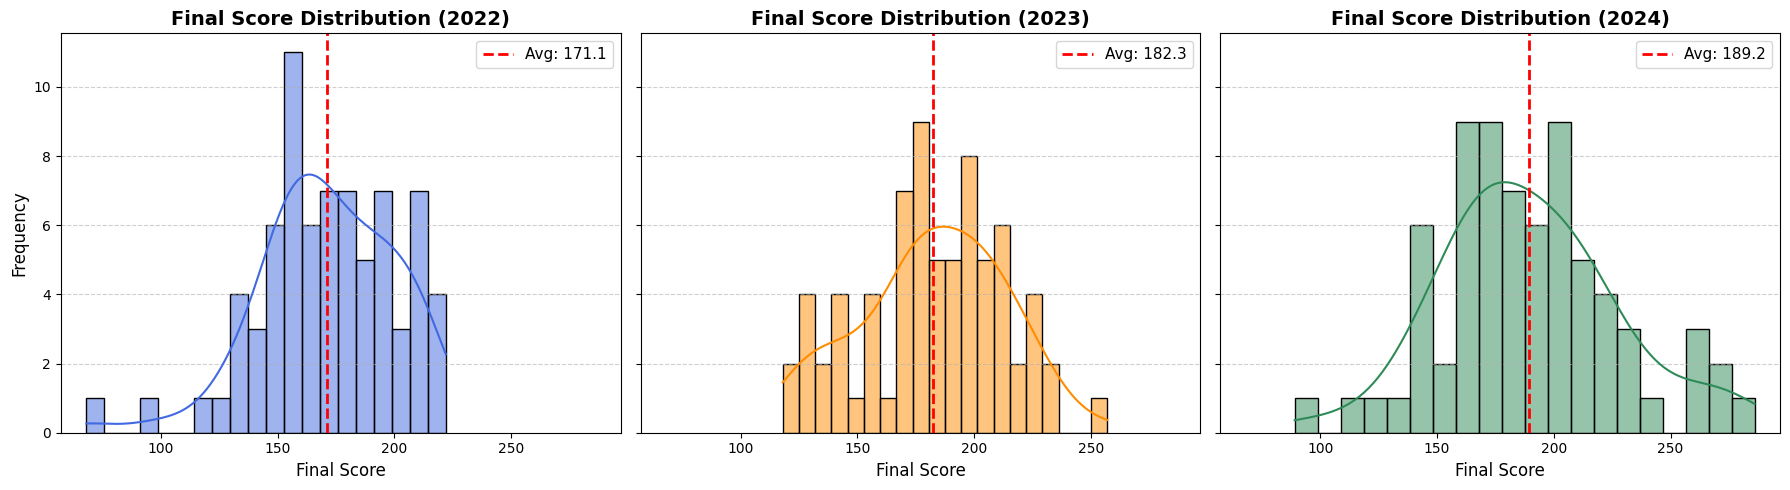

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

years = [2022, 2023, 2024]
colors = ["royalblue", "darkorange", "seagreen"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for i, year in enumerate(years):
    season_data = df_first_innings[df_first_innings["season"] == year]["Total_Runs"]
    avg_score = season_data.mean()

    sns.histplot(season_data, bins=20, kde=True, color=colors[i], ax=axes[i])

    axes[i].axvline(avg_score, color="red", linestyle="--", linewidth=2, label=f"Avg: {avg_score:.1f}")

    axes[i].set_title(f"Final Score Distribution ({year})", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Final Score", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    axes[i].legend(fontsize=11)
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


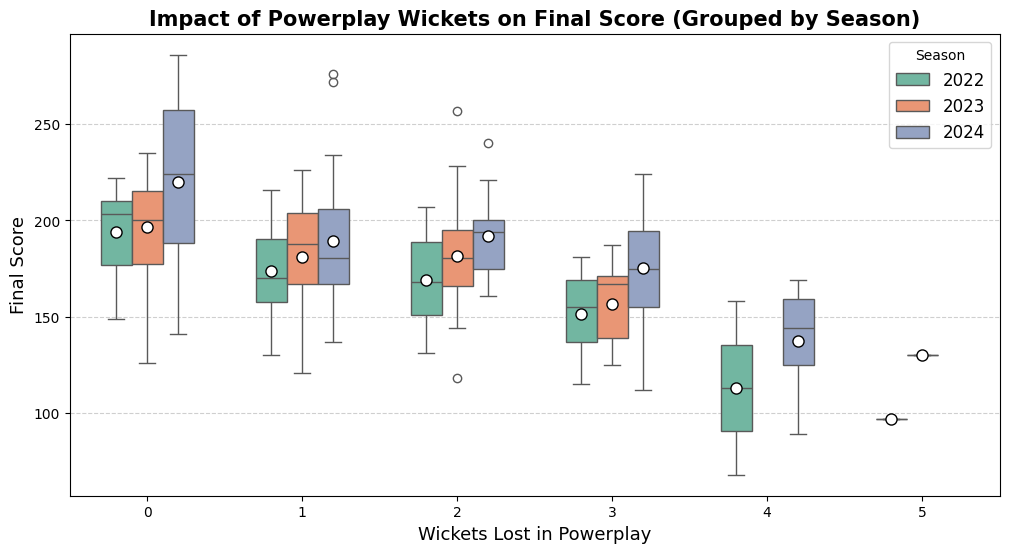

In [ ]:
plt.figure(figsize=(12, 6))


sns.boxplot(x=df_first_innings['Powerplay_Wickets'],
            y=df_first_innings['Total_Runs'],
            hue=df_first_innings['season'],
            palette="Set2", width=0.6, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white",
                       "markeredgecolor":"black", "markersize":"8"})


plt.xlabel("Wickets Lost in Powerplay", fontsize=13)
plt.ylabel("Final Score", fontsize=13)
plt.title("Impact of Powerplay Wickets on Final Score (Grouped by Season)", fontsize=15, fontweight="bold")
plt.legend(title="Season", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


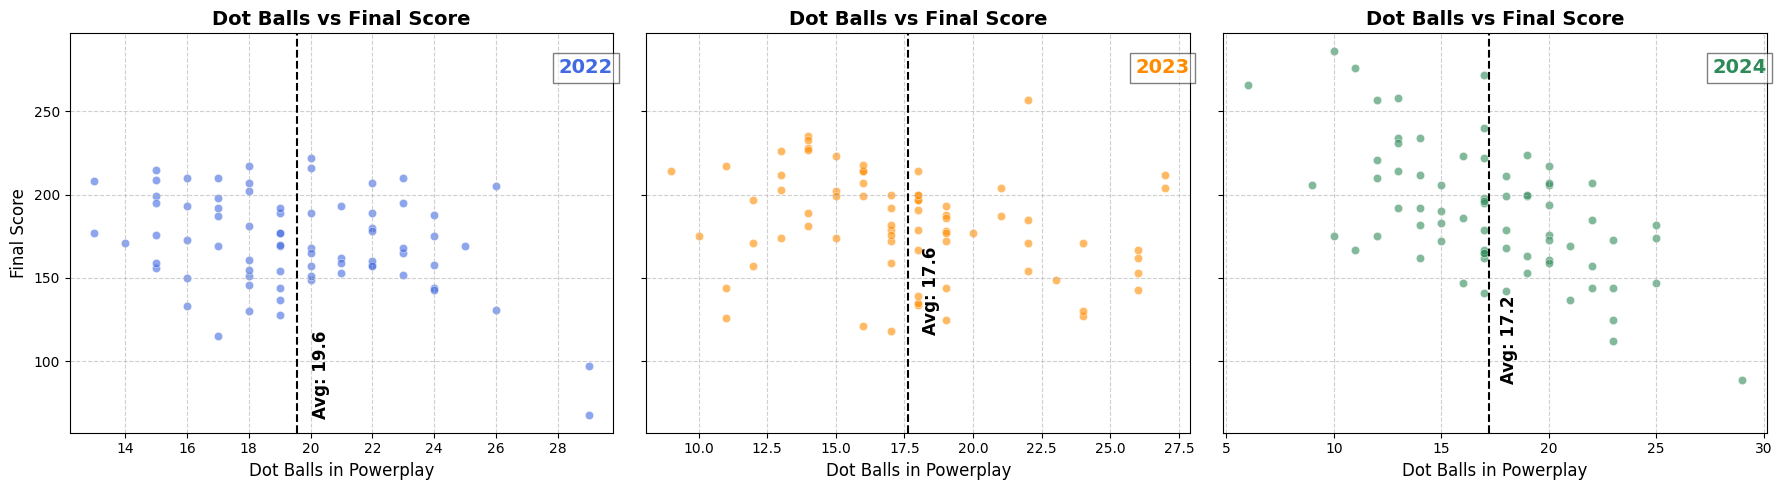

In [ ]:
years = [2022, 2023, 2024]
colors = ["royalblue", "darkorange", "seagreen"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, year in enumerate(years):
    season_data = df_first_innings[df_first_innings["season"] == year]

    sns.scatterplot(x=season_data["dot_ball"], y=season_data["Total_Runs"],
                    color=colors[i], alpha=0.6, ax=axes[i])

    # Calculate average dot balls for the season
    avg_dotballs = season_data["dot_ball"].mean()

    axes[i].axvline(avg_dotballs, color="black", linestyle="--", linewidth=1.5)

    axes[i].text(avg_dotballs + 0.5, season_data["Total_Runs"].min(),
                 f"Avg: {avg_dotballs:.1f}", color="black", fontsize=12, fontweight="bold", rotation=90)

    axes[i].text(0.9, 0.9, f"{year}", transform=axes[i].transAxes, fontsize=14,
                 fontweight="bold", color=colors[i], bbox=dict(facecolor='white', alpha=0.5))

    axes[i].set_title(f"Dot Balls vs Final Score", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Dot Balls in Powerplay", fontsize=12)
    if i == 0:
        axes[i].set_ylabel("Final Score", fontsize=12)

    axes[i].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


Linear Regression R² Score: 0.46
Mean Absolute Error (MAE): 20.30


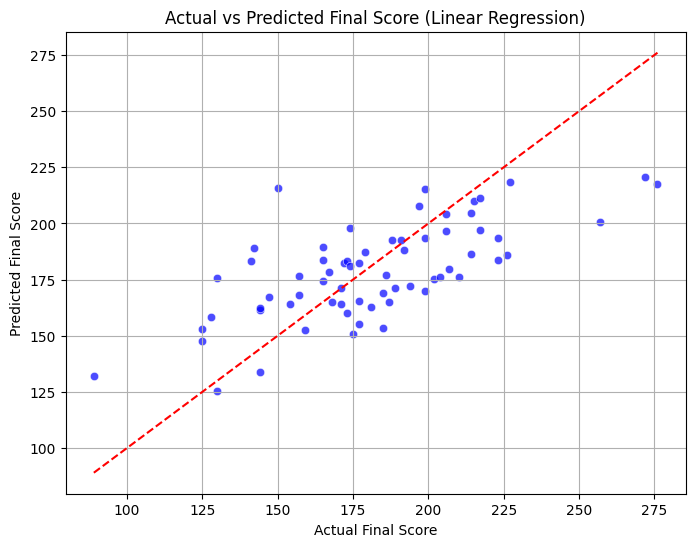

In [ ]:
# Using Linear Regression


# Select features (independent variables)
features = ['Powerplay_Runs', 'Powerplay_Wickets', 'Boundary_Count', 'dot_ball']
X = df_first_innings[features]

# Target variable (dependent variable)
y = df_first_innings['Total_Runs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)


r2 = r2_score(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)


print(f"Linear Regression R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Scatter plot of Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_lr, color="blue", alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")  # Perfect line
plt.xlabel("Actual Final Score")
plt.ylabel("Predicted Final Score")
plt.title("Actual vs Predicted Final Score (Linear Regression)")
plt.grid(True)
plt.show()


In [ ]:
# powerplay_runs = int(input("Enter Powerplay Runs: "))
# powerplay_wickets = int(input("Enter Powerplay Wickets Lost: "))
# boundary_count = int(input("Enter Boundary Count in Powerplay: "))
# dot_ball = int(input("Enter Dot Ball in Powerplay: "))

# # Convert input to DataFrame
# user_input = pd.DataFrame([[powerplay_runs, powerplay_wickets, boundary_count, dot_ball]], columns=features)

# # Predict using the trained Linear Regression model
# predicted_score = lr_model.predict(user_input).item()

# # Display the Predicted Score
# print(f"🏏 Predicted Final Score: {round(predicted_score)}")

Enter Powerplay Runs: 50
Enter Powerplay Wickets Lost: 1
Enter Boundary Count in Powerplay: 8
Enter Dot Ball in Powerplay: 10
🏏 Predicted Final Score: 187


Random Forest R² Score: 0.32
Mean Absolute Error (MAE): 20.30


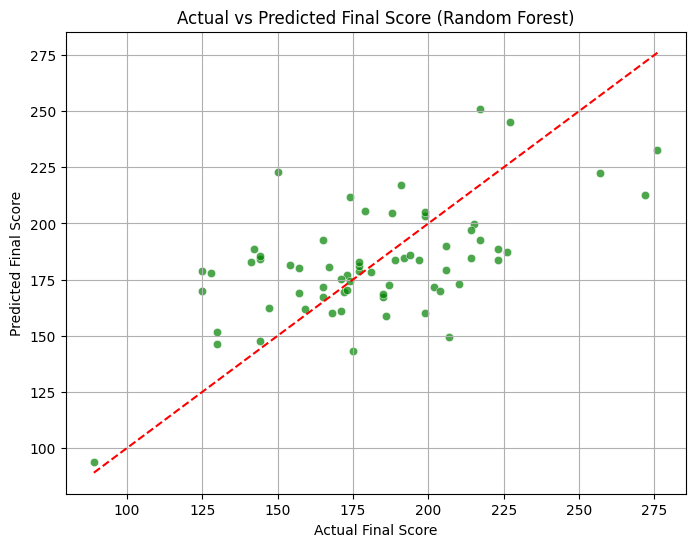

In [ ]:
features = ['Powerplay_Runs', 'Powerplay_Wickets', 'Boundary_Count', 'dot_ball']
X = df_first_innings[features]

# Target variable (dependent variable)
y = df_first_innings['Total_Runs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluate Model Performance
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_lr)


print(f"Random Forest R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Scatter plot of Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, color="green", alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("Actual Final Score")
plt.ylabel("Predicted Final Score")
plt.title("Actual vs Predicted Final Score (Random Forest)")
plt.grid(True)
plt.show()


In [ ]:
# powerplay_runs = int(input("Enter Powerplay Runs: "))
# powerplay_wickets = int(input("Enter Powerplay Wickets Lost: "))
# boundary_count = int(input("Enter Boundary Count in Powerplay: "))
# dot_ball = int(input("Enter Dot Ball in Powerplay: "))

# # Convert input to DataFrame
# user_input = pd.DataFrame([[powerplay_runs, powerplay_wickets, boundary_count, dot_ball]], columns=features)

# # Predict using the trained Random Forest model
# predicted_score = rf_model.predict(user_input).item()

# # Display the Predicted Score
# print(f"🏏 Predicted Final Score: {round(predicted_score)}")

Enter Powerplay Runs: 50
Enter Powerplay Wickets Lost: 1
Enter Boundary Count in Powerplay: 8
Enter Dot Ball in Powerplay: 10
🏏 Predicted Final Score: 175


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Select features and target variable
features = ['Powerplay_Runs', 'Powerplay_Wickets', 'Boundary_Count', 'dot_ball']
X = df_first_innings[features]
y = df_first_innings['Total_Runs']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Training Deep Learning Model (Keras)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, verbose=0)

# Predict using the Keras model
y_pred_keras = model.predict(X_test_scaled).flatten()

# Calculate R² scores
r2_keras = r2_score(y_test, y_pred_keras)

print(f"🏏 Weighted Model R² Score: {r2_keras:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
🏏 Weighted Model R² Score: 0.38


In [ ]:
# # 🎯 Take user inputs
# powerplay_runs = int(input("Enter Powerplay Runs: "))
# powerplay_wickets = int(input("Enter Powerplay Wickets Lost: "))
# boundary_count = int(input("Enter Boundary Count in Powerplay: "))
# dot_ball = int(input("Enter Dot Balls in Powerplay: "))


# features = ['Powerplay_Runs', 'Powerplay_Wickets', 'Boundary_Count', 'dot_ball']
# user_input = pd.DataFrame([[powerplay_runs, powerplay_wickets, boundary_count, dot_ball]], columns=features)

# user_input_scaled = scaler.transform(user_input)

# #  Predict using the Keras model
# predicted_score = model.predict(user_input_scaled).flatten()[0]

# # Display the Predicted Final Score
# print(f"\n🏏 Predicted Final Score based on Powerplay Performance (Keras Model): {round(predicted_score)}")


Enter Powerplay Runs: 50
Enter Powerplay Wickets Lost: 1
Enter Boundary Count in Powerplay: 8
Enter Dot Balls in Powerplay: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

🏏 Predicted Final Score based on Powerplay Performance (Keras Model): 189


In [ ]:
# Manually set R² scores
r2_lr = 0.46
r2_rf = 0.32
r2_dnn = 0.38

# Manually calculated weights
total_r2 = r2_lr + r2_rf + r2_dnn
w_lr = r2_lr / total_r2  # ~0.37
w_rf = r2_rf / total_r2  # ~0.26
w_dnn = r2_dnn / total_r2  # ~0.37

# User Inputs for Prediction
powerplay_runs = int(input("Enter Powerplay Runs: "))
powerplay_wickets = int(input("Enter Powerplay Wickets Lost: "))
boundary_count = int(input("Enter Boundary Count in Powerplay: "))
dot_ball = int(input("Enter Dot ball in Powerplay: "))

# Convert input to DataFrame
features = ['Powerplay_Runs', 'Powerplay_Wickets', 'Boundary_Count', 'dot_ball']
user_input_df = pd.DataFrame([[powerplay_runs, powerplay_wickets, boundary_count, dot_ball]], columns=features)

user_input_scaled = scaler.transform(user_input_df)

# Predict using all models
y_pred_lr = lr_model.predict(user_input_df).item()
y_pred_rf = rf_model.predict(user_input_df).item()
y_pred_dnn = model.predict(user_input_scaled).flatten()[0]

# Final Weighted Prediction
predicted_score = round((w_lr * y_pred_lr) + (w_rf * y_pred_rf) + (w_dnn * y_pred_dnn))

# Display Predicted Score
print(f"\n🏏 Predicted Final Score (Weighted Average): {predicted_score}")


Enter Powerplay Runs: 50
Enter Powerplay Wickets Lost: 1
Enter Boundary Count in Powerplay: 8
Enter Dot ball in Powerplay: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

🏏 Predicted Final Score (Weighted Average): 184
